# Time Series Forecasting with Arima

## Step 0 - Set Up Environment

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Step 1 - Collect Data

In [2]:
df = pd.read_csv(r"C:\Users\charl\OneDrive\Desktop\sample_superstore.csv",sep =',',encoding='windows-1254')
furniture = df.loc[df['Category'] == 'Furniture']

## Step 2 - Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [3]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [4]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [5]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [6]:
furniture.head()

,Order Date,Sales
0,1/1/2017,975.490
1,1/10/2014,51.940
2,1/10/2015,1018.104
3,1/10/2016,104.770
4,1/11/2014,9.940


Set Index for Time Series Data

In [7]:
furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2017-01-01', '2014-01-10', '2015-01-10', '2016-01-10',
               '2014-01-11', '2016-01-11', '2017-01-12', '2014-01-13',
               '2015-01-13', '2017-01-13',
               ...
               '2014-09-07', '2015-09-07', '2017-09-07', '2014-09-08',
               '2015-09-08', '2016-09-08', '2017-09-08', '2014-09-09',
               '2016-09-09', '2017-09-09'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [8]:
y = furniture['Sales'].resample('MS').mean()

## Step 3 - Data Exploration

### Visualize Data

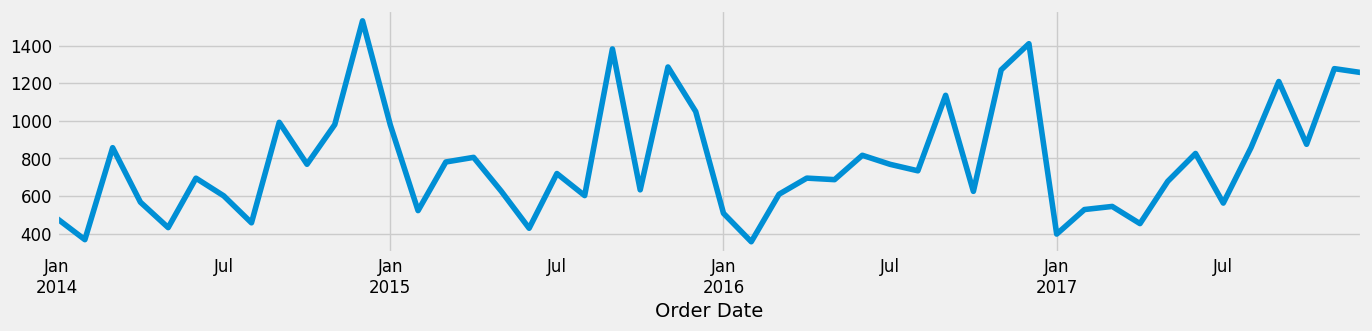

In [9]:
y.plot(figsize=(15, 3))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

### Decompose Data 
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

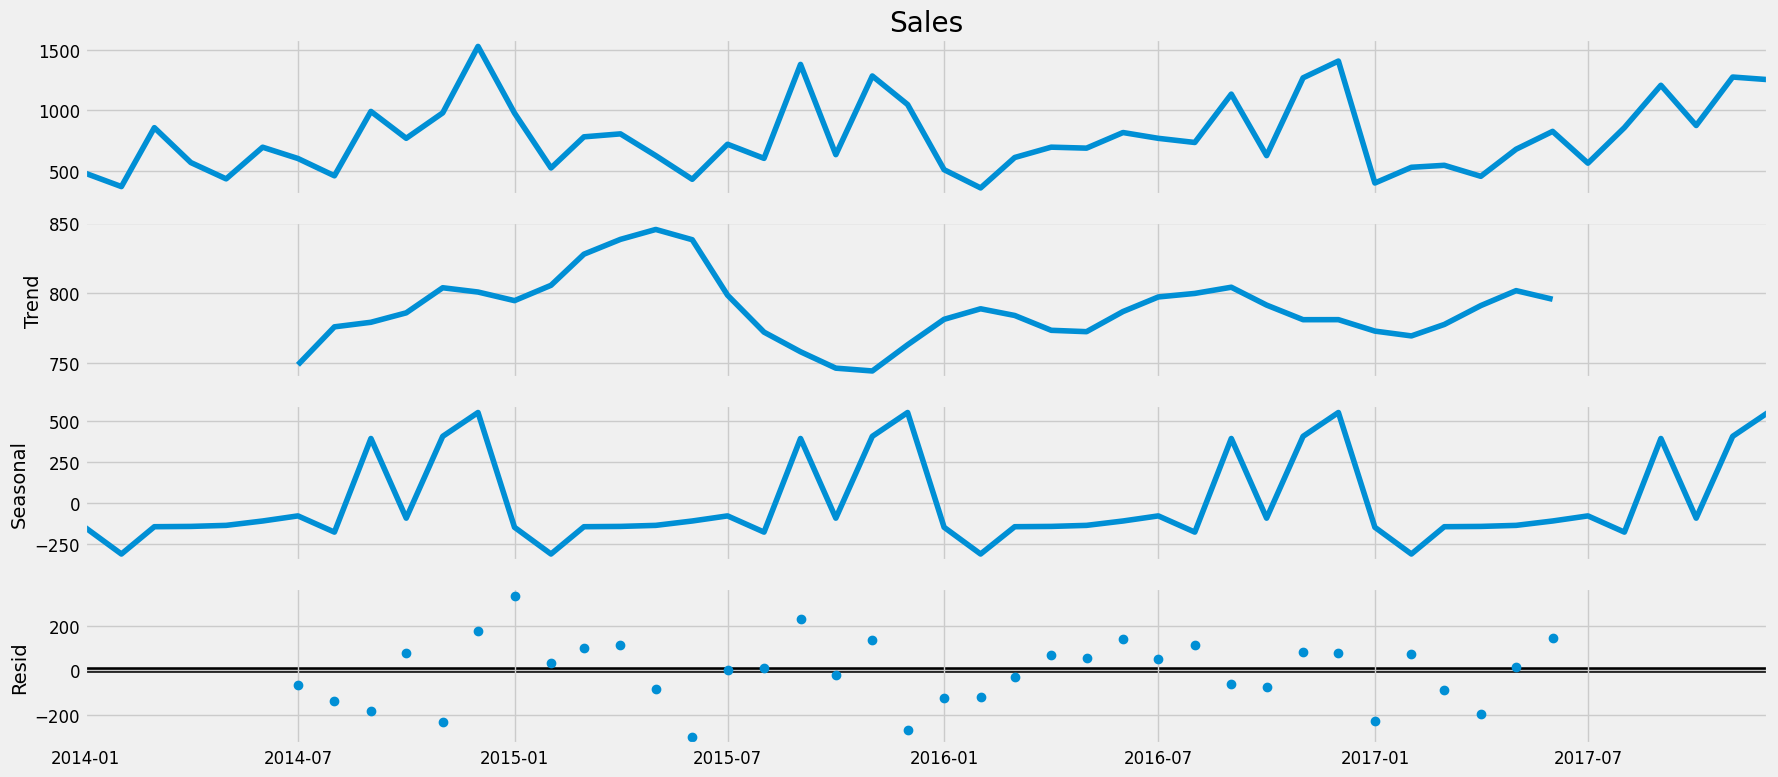

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

### Testing for  Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(y)
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.191070
p-value: 0.000009


A p-value below 0.05 indicates stationarity, and our data meets this criterion, so we do not need to difference it.

## Step 4 - Model Building

### Set Paramaters 
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data

In [12]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [13]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1648.1567372757302
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920111
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997936407
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1232.1145491133823
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.00471991163414
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280302578
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758097


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2687.5782590646995
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809164
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673287


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.60256751595784
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2287.4528565733203
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946869
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.87255764351045
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1458.8906785355275
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567211039
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.96712281679555
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1387.4354651404647
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109212
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.91132001514114
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176816874
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2563.2447986472835
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.87055484827937
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.58062333033416
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442629


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1634.8090843898367
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417254
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5576621461247
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1447.3901702383832
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.4632147852136


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.2077675160974
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.92593679351995


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1032.7060191852936
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.466467508459
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921437865
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442185991


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2659.3256011838885
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815026
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.3422193965947
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323877574
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2177.178849906198


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560022851515
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.75131881234586
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1390.4391298352543
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.20034222811347


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.21306116190965
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658785063


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1400.05137852157
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345405
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.32649925107285
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835026
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2447.874000586573


C:\Users\charl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687609704
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939387
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546607863
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2260.9300566158345
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439543526
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.36610144900703


AIC is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data. The best-fit model according to AIC is the one that explains the greatest amount of variation using the fewest possible independent variables.

here the order (1,1,1) and seasonal order (1,1,1,12) explains the greatest amount of variation using the fewest amount of independent variables

### fit arima

In [14]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                               # enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0854      0.240      0.356      0.722      -0.385       0.556
ma.L1         -1.0000   3177.990     -0.000      1.000   -6229.747    6227.747
ar.S.L12       0.0274      0.512      0.053      0.957      -0.977       1.032
ma.S.L12      -1.0001   3177.648     -0.000      1.000   -6229.076    6227.076
sigma2      2.715e+04      0.050   5.42e+05      0.000    2.71e+04    2.71e+04


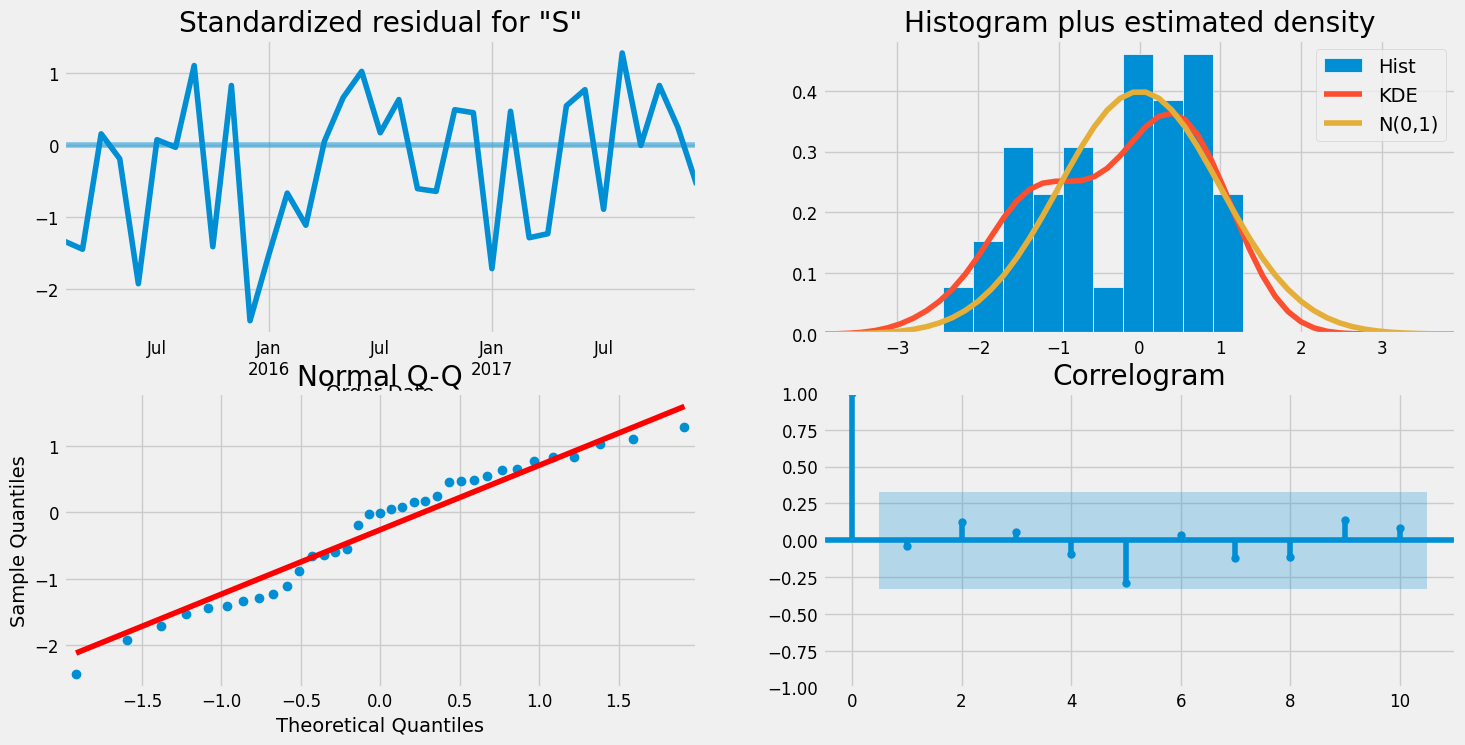

In [15]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Step 5 - Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

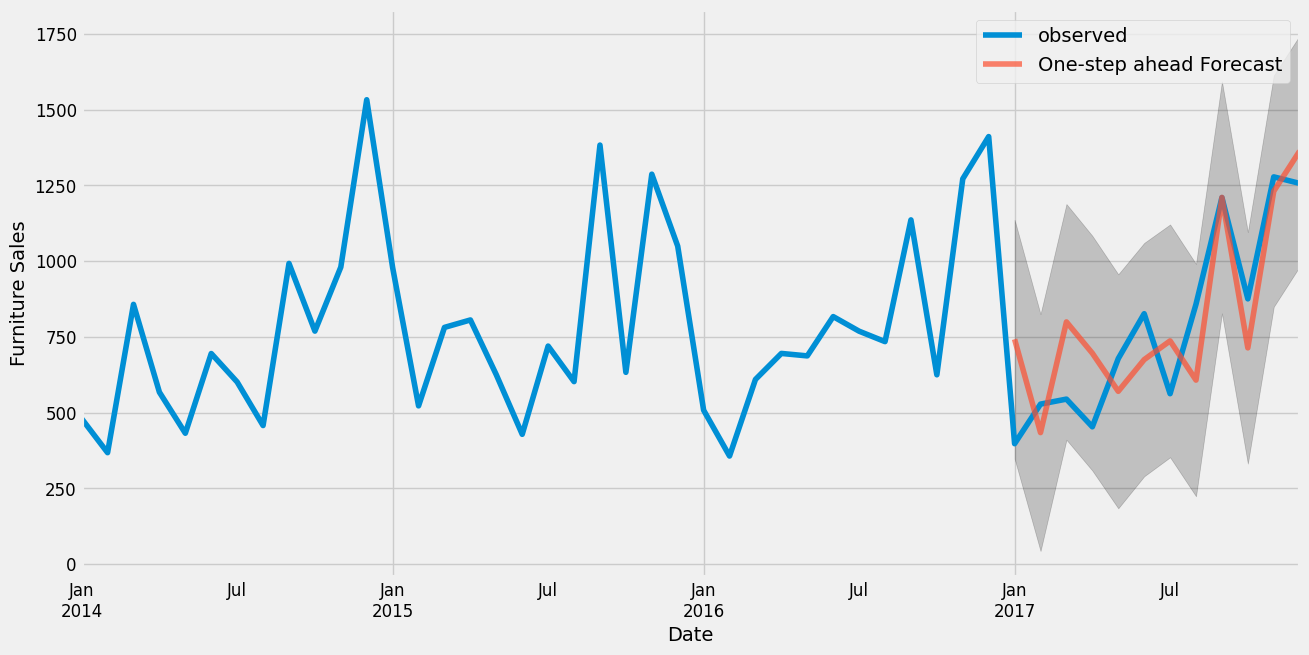

In [16]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

### Calculate MSE and RMSE

In [17]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 34904.03


In [18]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 186.83


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

## Step 6 - Forecast

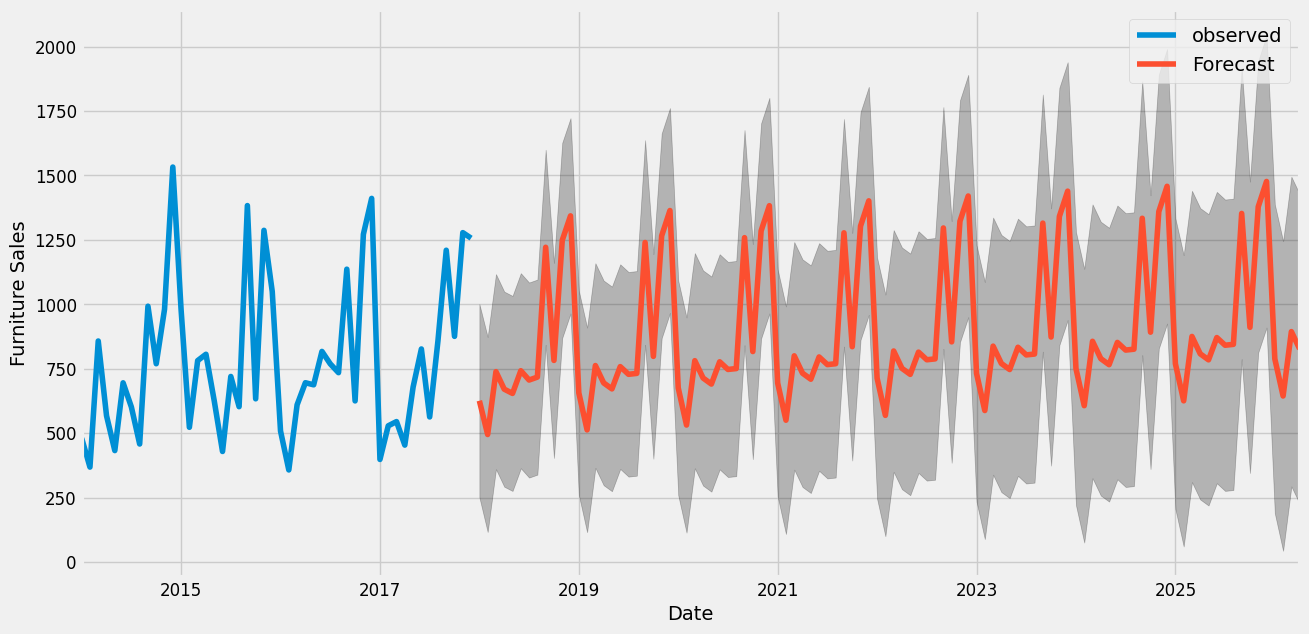

In [19]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.